In [1]:
import numpy as np
import pandas as pd
from google.colab import drive
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch
from torch.utils.data import Dataset, DataLoader
import pickle
import random
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score,f1_score,confusion_matrix,roc_auc_score,ConfusionMatrixDisplay
from sklearn.preprocessing import MinMaxScaler

In [2]:

drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
main_dir = 'drive/MyDrive/2023JHU/MLMA_EOG/isolated 2/'
os.listdir(main_dir)

['ReadMe', '.DS_Store', '005', '004', '003', '001', '006', '002']

In [4]:
# get file list for 1 patient
def get_file_list(path):
    file_list = []
    label = []
    for i in os.listdir(path):
        file_list.append(i)
        if i.endswith("001.csv"):
            label.append(0)
        elif i.endswith("002.csv"):
            label.append(1)
        elif i.endswith("003.csv"):
            label.append(2)
        elif i.endswith("004.csv"):
            label.append(3)
        elif i.endswith("005.csv"):
            label.append(4)
        elif i.endswith("006.csv"):
            label.append(5)
        elif i.endswith("007.csv"):
            label.append(6)
        elif i.endswith("008.csv"):
            label.append(7)
        elif i.endswith("009.csv"):
            label.append(8)
        elif i.endswith("010.csv"):
            label.append(9)
        elif i.endswith("011.csv"):
            label.append(10)
        elif i.endswith("012.csv"):
            label.append(11)

    
    return label,file_list

In [5]:
# get feature from 1 file and normalize
def get_feature(path):
    f = []
    scaler = MinMaxScaler()
    a = pd.read_csv(path,names=["vertical","horizontal"])
    a = np.array(a)
    a = scaler.fit_transform(a)
    a = np.swapaxes(a,0,1)
    f.append(a)
    return f
    
    

In [6]:
# self identified test_split
def my_train_test_split_user_dependent(path,test_split,file_list,label):
    X_test = []
    X_train = []
    y_train = []
    y_test = []
    for f in range(len(file_list)):
        file = file_list[f]
        file_label = label[f]
        feature = get_feature(str(path+file))
        #print(file.split('_')[2],file_label)
        if file.split('_')[2] in test_split:
            X_test.append(feature)
            y_test.append(file_label)
            #print(file,len(feature))
        else:
            X_train.append(feature)
            y_train.append(file_label)
            #print(file)

    X_train = np.array(X_train)
    X_test = np.array(X_test)
    y_train = np.array(y_train)
    y_test = np.array(y_test)
    return X_train,X_test, y_train,y_test

In [7]:
def evaluate(y_true, y_pred,y_prob):
    f1 = f1_score(y_true, y_pred,average = 'micro')
    acc = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[0,1,2,3,4,5,6,7,8,9,10,11])
    disp.plot()
    plt.show()
    class_accuracy = cm.diagonal()/cm.sum(axis=1)
    specificity = class_accuracy[1]
    sensitivity = class_accuracy[0]
    auc = roc_auc_score(y_true,y_prob,multi_class="ovr",average="micro")

    return f1,acc,specificity,sensitivity,auc,cm

In [8]:
class classficiation(nn.Module):
    def __init__(self):
        super(classficiation, self).__init__()
        self.encoder = nn.Sequential(
            # your codes here
            nn.Conv2d(1,32,2,stride = 1),
            nn.ReLU(),
            nn.BatchNorm2d(32,momentum=0.99),
            nn.Dropout(p=0.5),
            nn.Conv2d(32,16,1,stride = 1),
            nn.ReLU()   
        )


        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(19984,200),
            nn.ReLU(),
            nn.Linear(200,12)
            #nn.Softmax()
        )



    def forward(self, x):
         # your codes here
        encoder = self.encoder(x)
        #print(encoder.shape)
        x = self.classifier(encoder)

        return x 




In [9]:
# Define custom dataset class
class MYDataset(Dataset):
    def __init__(self, feature,label):
      self.feature = []
      self.label = []
      for i in range(len(feature)):
        self.feature.append(feature[i])
        self.label.append(label[i])

    def __len__(self):
        return len(self.label)

    def __getitem__(self, idx):
        f = self.feature[idx]
        #f = f[np.newaxis,:,:]
        l = self.label[idx]
        return f, l


# User Dependent

In [10]:
patient = ["001","002","003","004","005","006"]
test_split = [["01","02"],["03","04"],["05","06"],["07","08"],["09","10"]]

In [11]:
#### def training
def train(model,train_dataloader,num_epochs,optimizer,criterion):
  train_loss = []
  model = model.to(device)
  for epoch in range(num_epochs):
        #print("running epoch: ", epoch)
        model.train()
        Loss = 0
        train_label = []
        train_ypred = []
        for i, (feature,label) in enumerate(train_dataloader, 0):
          #print(feature.shape)
          optimizer.zero_grad()
          feature = feature.to(device)
          output = model(feature.float())
          ypred = torch.argmax(output.cpu(),dim=1)
          #print(feature.shape,output.shape)
          #print(ypred)
          for j in ypred:
            train_ypred.append(j)
          for j in label:
            train_label.append(j)
          loss = criterion(output,label.to(device))
          loss.backward()
          optimizer.step()
          Loss += loss.item()
        Loss = Loss/(i+1)
        acc = accuracy_score(y_true=train_label, y_pred= train_ypred)
        train_loss.append(Loss)
  model.eval()

        #print("train loss: ",Loss," train accuracy: ",acc)
  return model

In [12]:
def eval(model,test_dataloader,m):
  with torch.no_grad():
    model.eval()
    label_list = []
    ypred_list = []
    yprob_list = []
        #Loss = 0
    for i, (feature,label) in enumerate(test_dataloader, 0):
      feature = feature.to(device)
      output = model(feature.float())
      #print(output.shape)
      ypred = torch.argmax(output,dim=1)
      yprob = m(output)
      for j in ypred.cpu().detach().numpy():
        ypred_list.append(j)
      for l in label.cpu().detach().numpy():
        label_list.append(l)
      for l in yprob.cpu().detach().numpy():
        yprob_list.append(l)
    f1,acc,specificity,sensitivity,auc,cm = evaluate(label_list, ypred_list,yprob_list)

    #print("test acc: ", acc)
    return f1,acc,specificity,sensitivity,auc

## train 5-fold cross validation

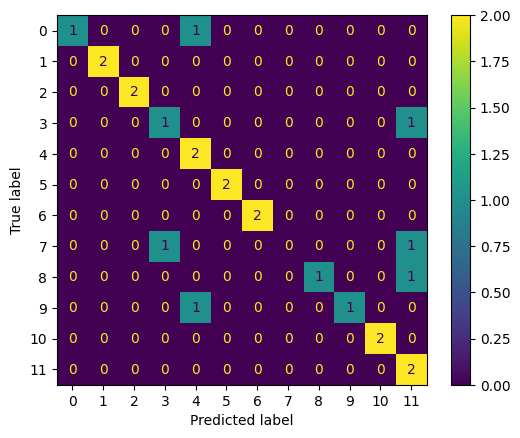

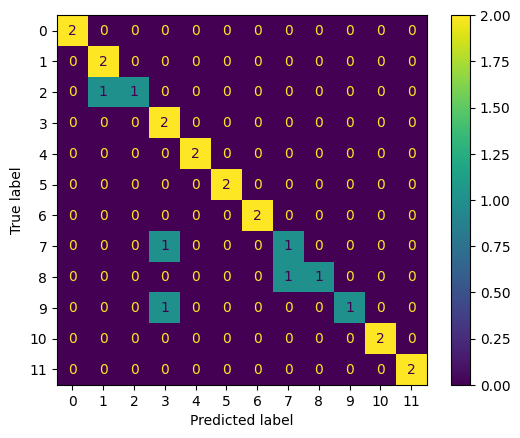

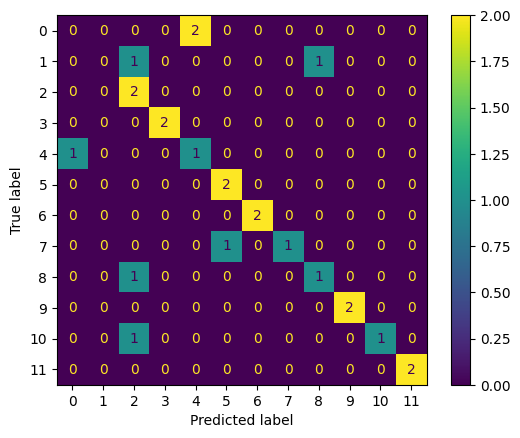

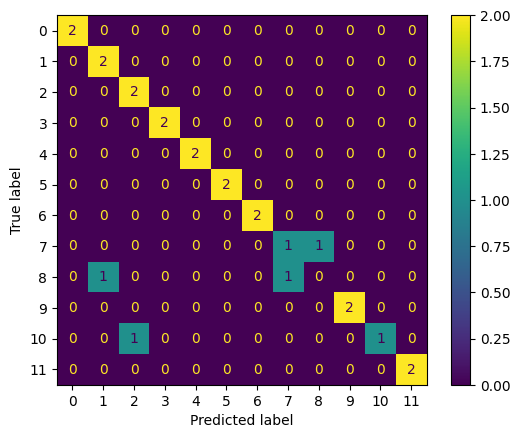

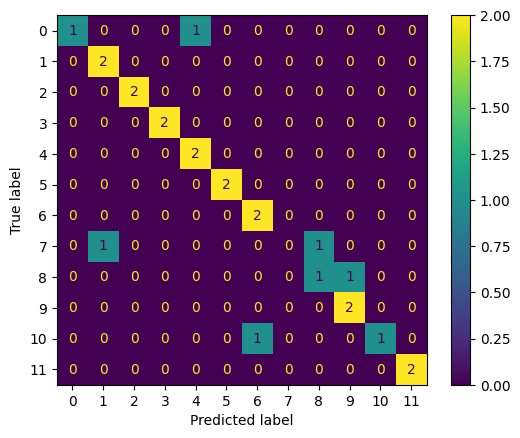

001 0.775 0.775 0.9812184343434345 0.8 0.6


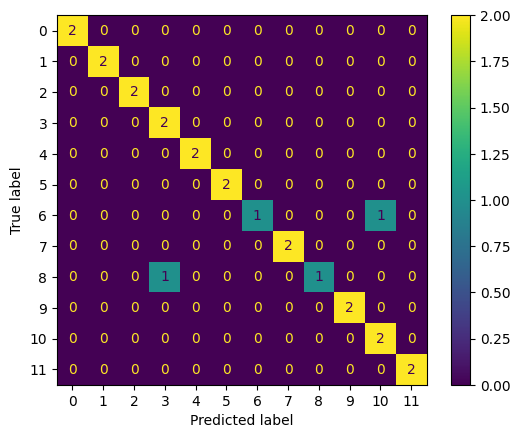

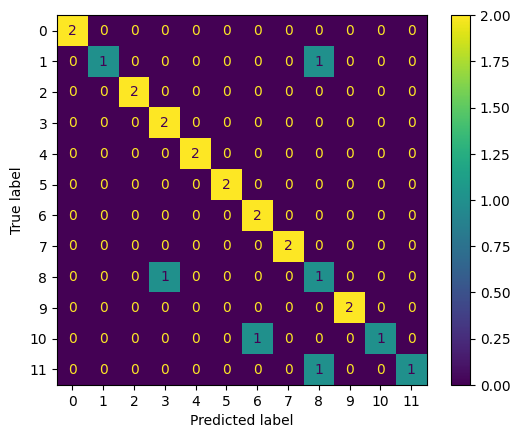

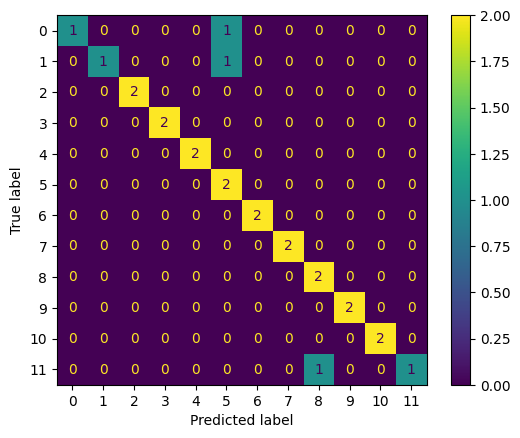

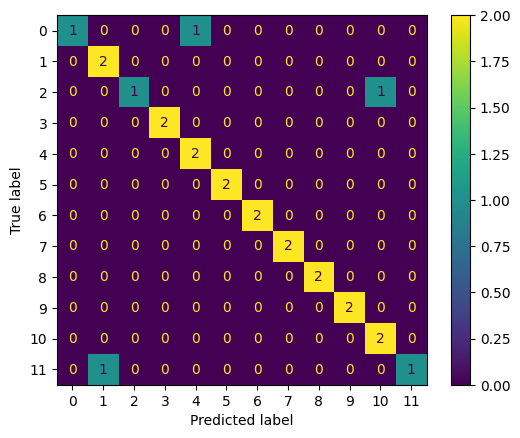

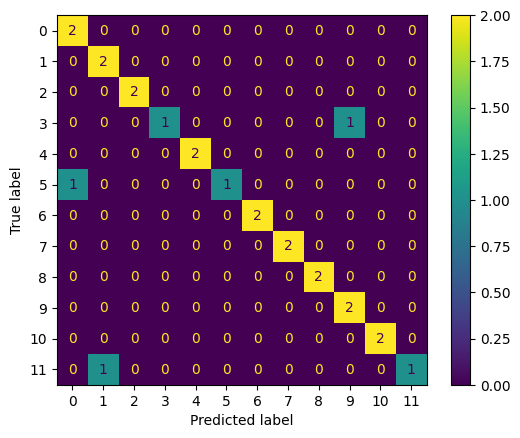

002 0.875 0.875 0.9946338383838385 0.8 0.8


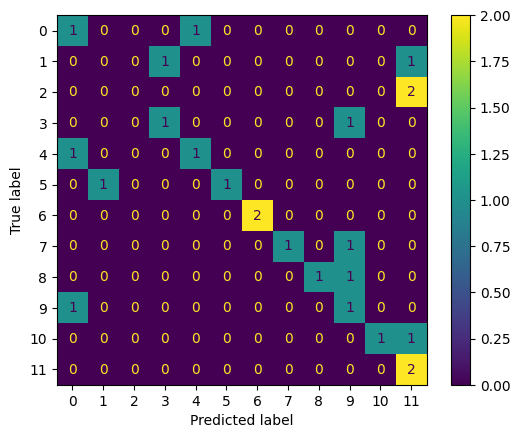

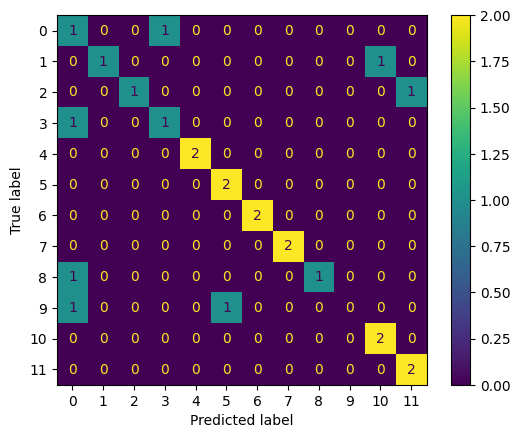

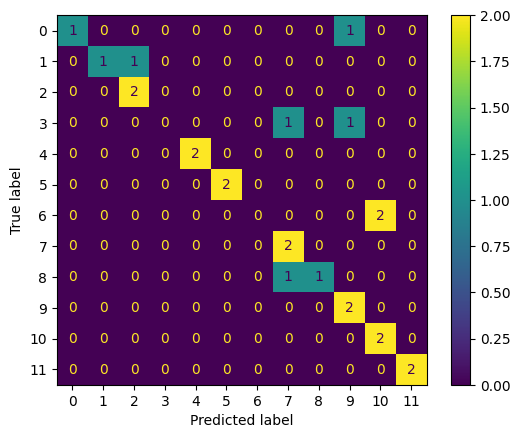

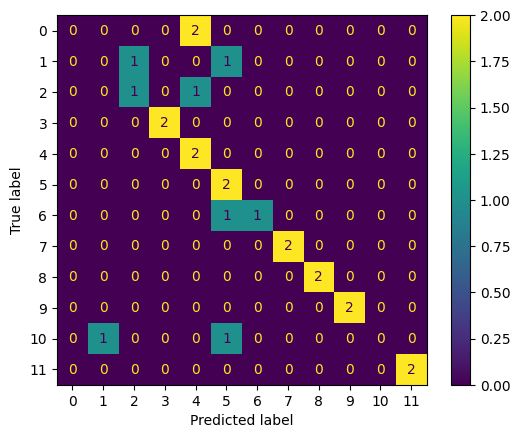

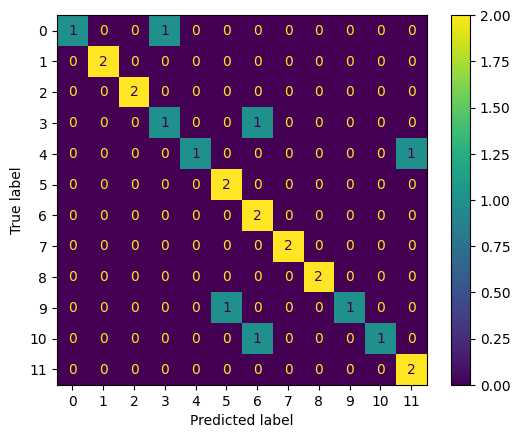

003 0.675 0.675 0.9361426767676768 0.4 0.4


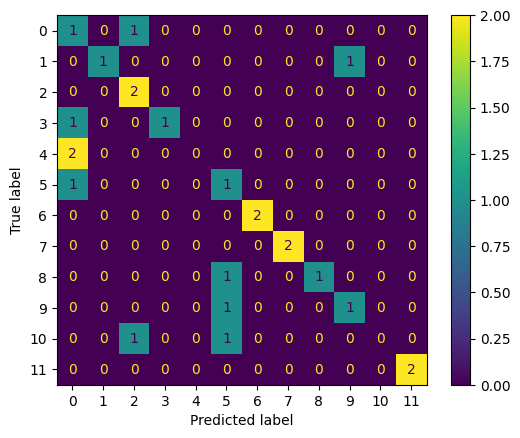

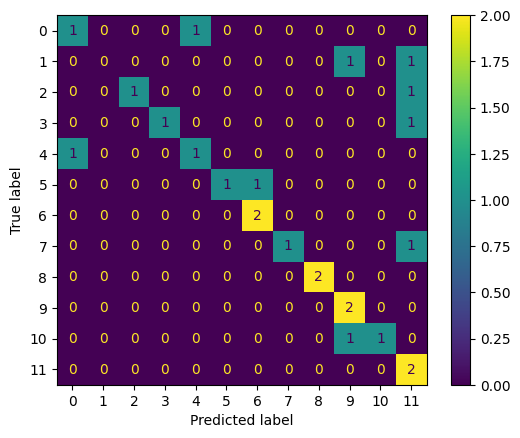

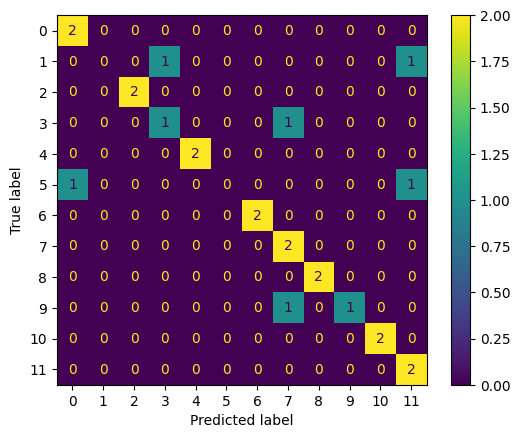

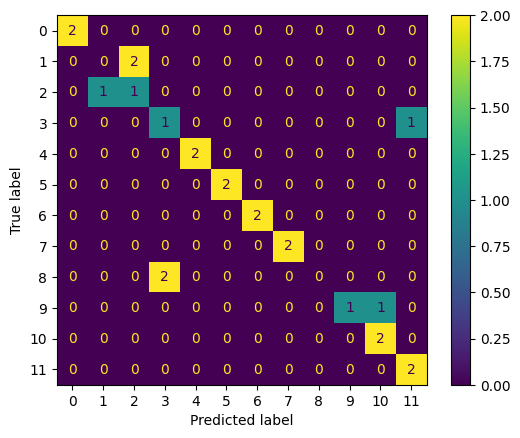

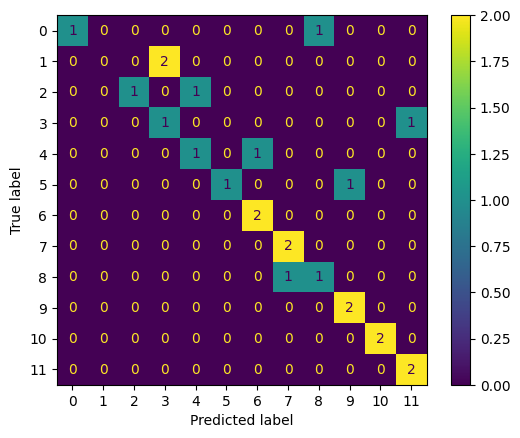

004 0.6666666666666667 0.6666666666666667 0.9234848484848485 0.1 0.7


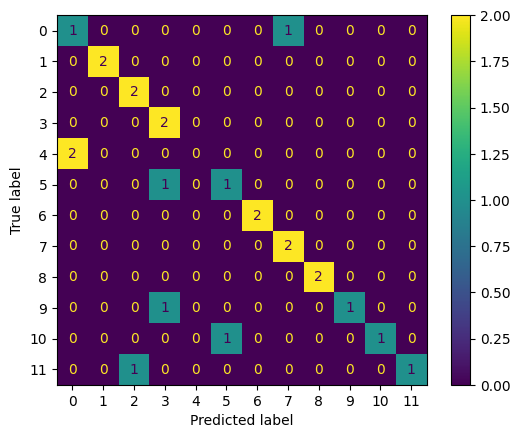

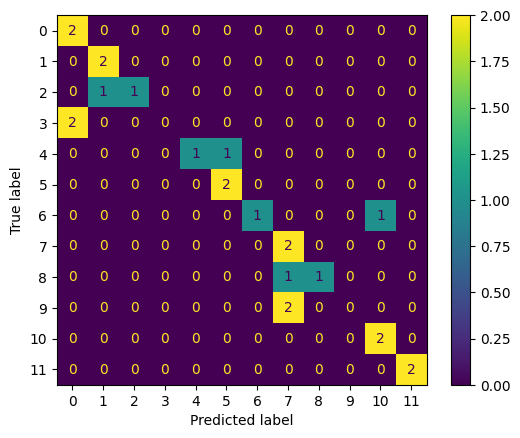

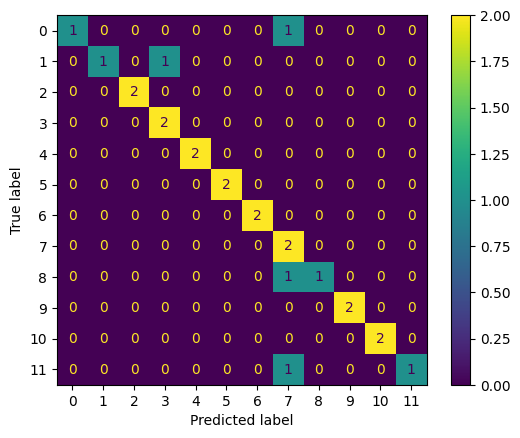

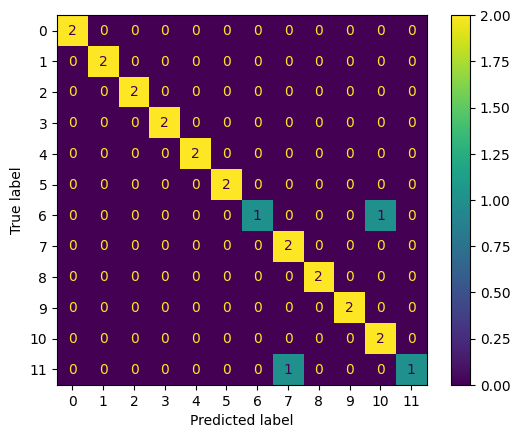

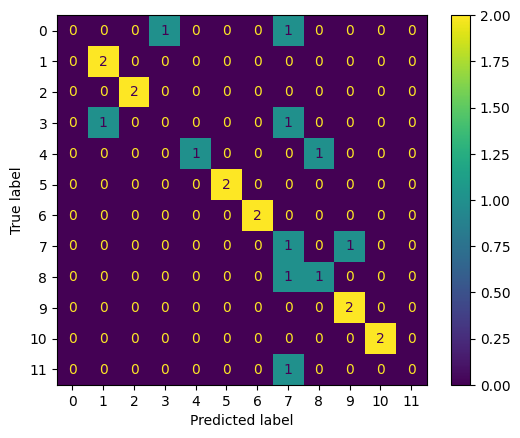

005 0.7554347826086957 0.7554347826086957 0.9752627288957629 0.9 0.6


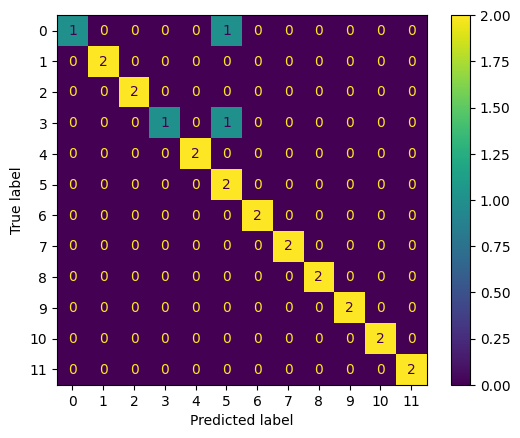

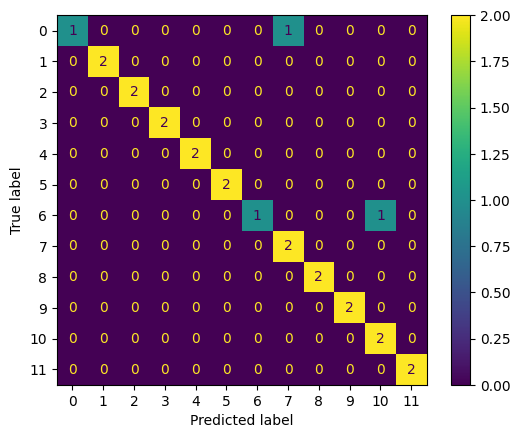

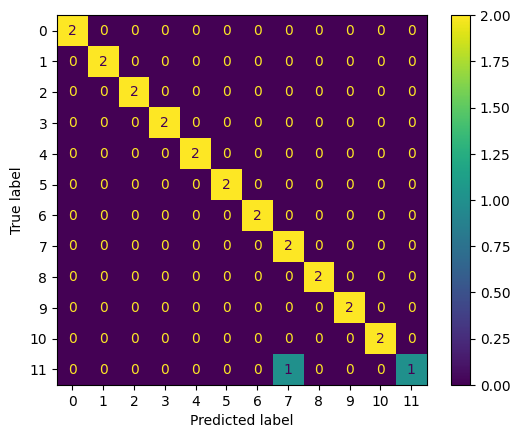

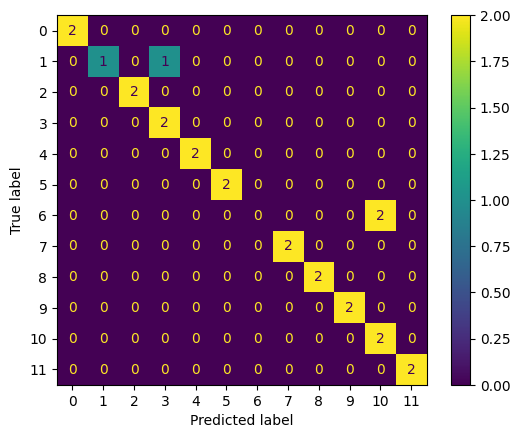

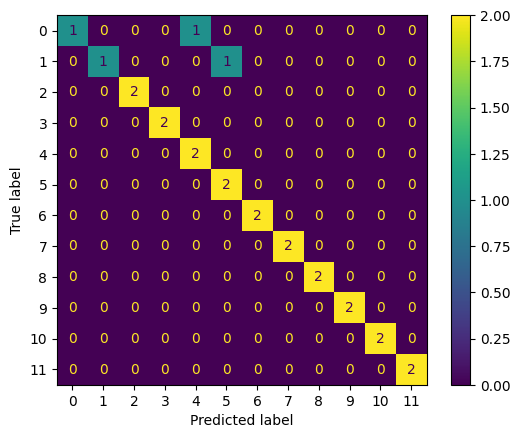

006 0.9166666666666666 0.9166666666666666 0.9936553030303029 0.8 0.7


In [13]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
m = nn.Softmax(dim=1).to(device)
Total_acc = []
total_f1 = []
total_auc = []
total_spec = []
total_sens = []
for p in patient:
    #print(p)
    output_pck = []
    path = path = str(main_dir+p+"/isolated_strokes/")
    Acc = 0
    F1 = 0
    AUC = 0
    Spec = 0
    Sens = 0
    for t in test_split:
        label,file_list = get_file_list(path)
        X_train,X_test, y_train,y_test = my_train_test_split_user_dependent(path,t,file_list,label)
        #print(X_train.shape,X_test.shape, y_train.shape,y_test.shape)
        train_data = MYDataset(X_train,y_train)
        train_dataloader  = DataLoader(train_data, batch_size=16, shuffle=True)
        test_data = MYDataset(X_test,y_test)
        test_dataloader  = DataLoader(test_data, batch_size=16, shuffle=True)
        
        # set new model
        torch.manual_seed(42)
        model = classficiation()
        lr = 0.0001
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
        criterion = nn.CrossEntropyLoss()
        num_epochs = 50
        # train 
        model = train(model,train_dataloader,num_epochs,optimizer,criterion)
        # evaluate 
        f1,acc,specificity,sensitivity,auc = eval(model,test_dataloader,m)
        Acc += acc
        F1 += f1
        AUC += auc
        Spec += specificity
        Sens += sensitivity
    print(p,Acc/5,F1/5,AUC/5,Spec/5,Sens/5)
    Total_acc.append(Acc/5)
    total_f1.append(F1/5)
    total_auc.append(AUC/5)
    total_spec.append(Spec/5)
    total_sens.append(Sens/5)



In [18]:
print("Total",np.mean(np.array(Total_acc)),np.mean(np.array(total_f1)),np.mean(np.array(total_auc)),np.mean(np.array(total_spec)),np.mean(np.array(total_sens)))


Total 0.7772946859903382 0.7772946859903382 0.967399638317644 0.6333333333333333 0.6333333333333333


# Split on patient level - User-independent

In [14]:
# self identified test_split
def my_train_test_split_user_independent(test_patient,train_patient):
    X_test = []
    X_train = []
    y_train = []
    y_test = []
    for p in train_patient:
        path = str(main_dir+p+"/isolated_strokes/")
        label,file_list = get_file_list(path)
        for i in range(len(file_list)):
            file = file_list[i]
            file_label = label[i]
            feature = get_feature(str(path+file))
            X_train.append(feature)
            y_train.append(file_label)
        
    path = str(main_dir+test_patient+"/isolated_strokes/")
    label,file_list = get_file_list(path)
    for i in range(len(file_list)):
        file = file_list[i]
        file_label = label[i]
        feature = get_feature(str(path+file))
        X_test.append(feature)
        y_test.append(file_label)

    X_train = np.array(X_train)
    X_test = np.array(X_test)
    y_train = np.array(y_train)
    y_test = np.array(y_test)
    return X_train,X_test, y_train,y_test

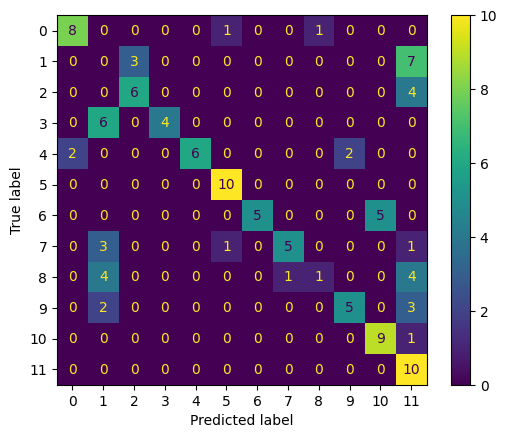

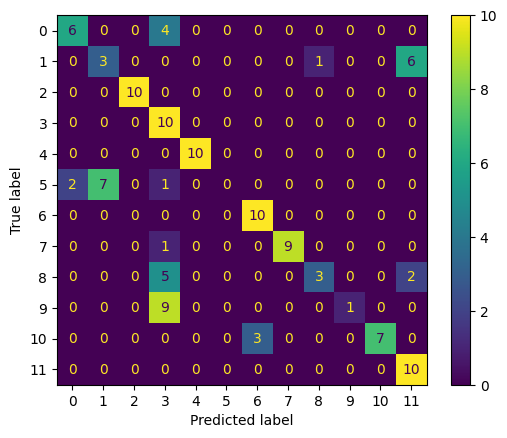

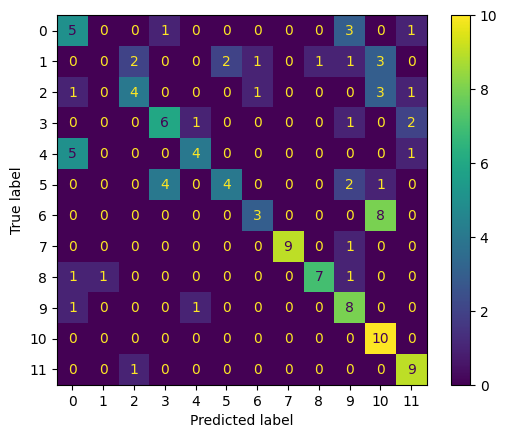

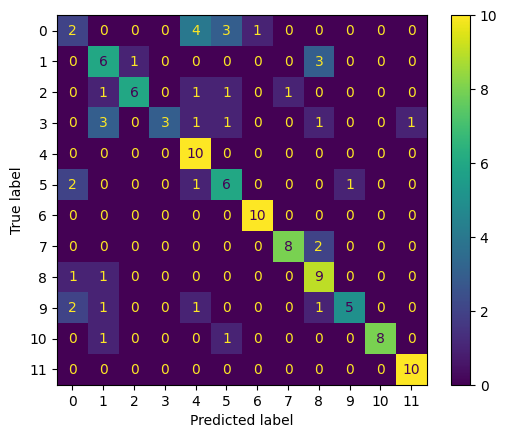

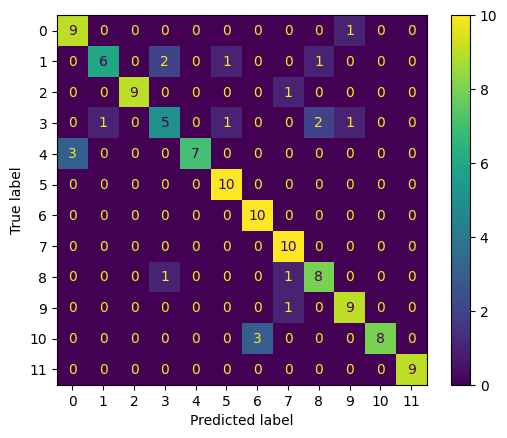

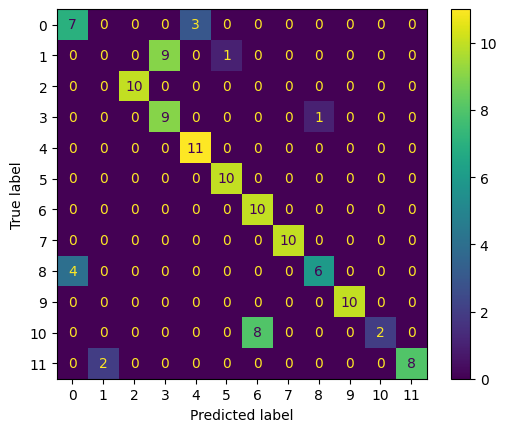

total acc 4.086785891703925 4.086785891703925 5.721779716450719 1.5 3.7


In [15]:
patient = ["001","002","003","004","005","006"]
Acc = 0
F1 = 0
AUC = 0
Spec = 0
Sens = 0
for test_patient in patient:
    train_patient= ["001","002","003","004","005","006"]
    train_patient.remove(test_patient)
    X_train,X_test, y_train,y_test = my_train_test_split_user_independent(test_patient,train_patient)
    train_data = MYDataset(X_train,y_train)
    train_dataloader  = DataLoader(train_data, batch_size=16, shuffle=True)
    test_data = MYDataset(X_test,y_test)
    test_dataloader  = DataLoader(test_data, batch_size=16, shuffle=True)
        
    # set new model
    torch.manual_seed(42)
    model = classficiation()
    lr = 0.0001
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    criterion = nn.CrossEntropyLoss()
    num_epochs = 50
        # train 
    model = train(model,train_dataloader,num_epochs,optimizer,criterion)
        # evaluate 
    f1,acc,specificity,sensitivity,auc = eval(model,test_dataloader,m)
    Acc += acc
    F1 += f1
    AUC += auc
    Spec += specificity
    Sens += sensitivity
print("total acc", Acc/6,F1/6,AUC/6,Spec/6,Sens/6 )

In [19]:
print("total acc", Acc/6,F1/6,AUC/6,Spec/6,Sens/6 )

total acc 0.6811309819506541 0.6811309819506541 0.9536299527417865 0.25 0.6166666666666667
